In [45]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [46]:
import numpy as np
import pandas as pd

In [67]:
import datetime 
from matplotlib import dates as mdates

# Reflect Tables into SQLAlchemy ORM

In [59]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [60]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [50]:
# reflect an existing database into a new model
Base = automap_base()
#reflect tables
Base.prepare(engine, reflect=True)


In [61]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [62]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [63]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [64]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [69]:

#save start date and end date
start_date = datetime.date(2019, 1, 4)
end_date = datetime.date(2019, 1, 18)

In [43]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

In [70]:
#inspect how the dates are formatted
sample_dates = session.query(Measurement.date).limit(5).all()
for result in sample_dates:
    print(result)

('2010-01-01',)
('2010-01-02',)
('2010-01-03',)
('2010-01-04',)
('2010-01-06',)


In [71]:
#getting the maximum date after formatting the dates appropriately

max_date = session.query(func.max(func.strftime("%Y-%m-%d", Measurement.date))).limit(5).all()
max_date[0][0]

'2017-08-23'

In [72]:
#access all precipitation data from the last year (as the end of the data is our endpoint, we only need one comparison)
precip_data = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= datetime.date(2016, 8, 23)).all()


In [73]:
#load as a dataframe
precip_df = pd.DataFrame(precip_data, columns = ['date', 'precipitation'])

#set index
precip_df.set_index('date', inplace = True)

#look at dataframe
precip_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [74]:
#sort data frame
precip_df = precip_df.sort_values(by = 'date')
precip_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


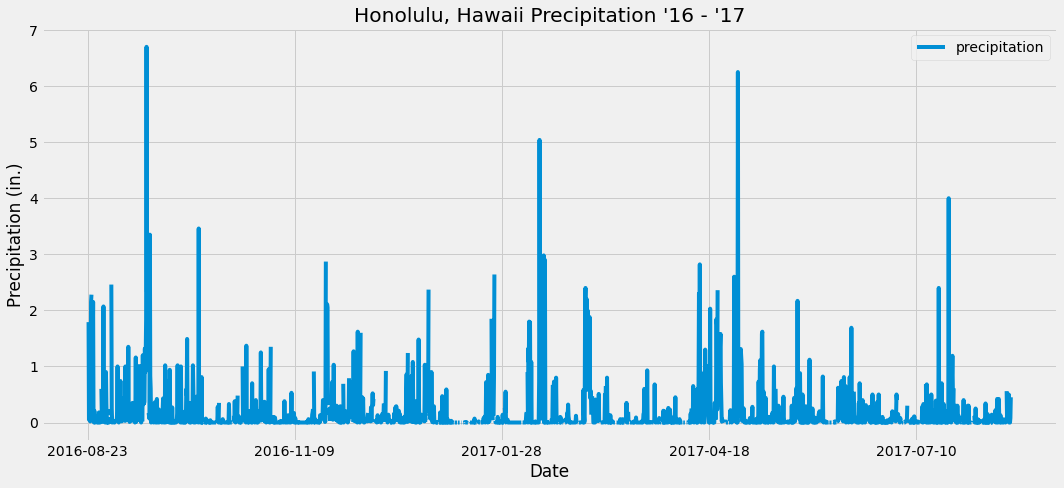

In [110]:
#plot data
fig, ax = plt.subplots(figsize = (15, 7))
precip_df.plot(ax = ax, x_compat = True)

#set title and labels
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (in.)')
ax.set_title("Honolulu, Hawaii Precipitation '16 - '17")

#plot figure
plt.tight_layout()
plt.show()

In [77]:
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [78]:
#count distinct stations
num_of_stations = session.query(Station.id).distinct().count()
num_of_stations

9

In [79]:
#we wish to see which of the nine stations are the most active, so we will count the number of observations for each station. To do this, we must join the tables.
station_counts = session.query(Station.station, func.count(Measurement.id)).select_from(Measurement).\
    join(Station, Measurement.station == Station.station).group_by(Station.station).\
    order_by(func.count(Measurement.id).desc()).all()

for result in station_counts:
    print(f"Station: {result[0]}\tCount: {result[1]}")

Station: USC00519281	Count: 2772
Station: USC00519397	Count: 2724
Station: USC00513117	Count: 2709
Station: USC00519523	Count: 2669
Station: USC00516128	Count: 2612
Station: USC00514830	Count: 2202
Station: USC00511918	Count: 1979
Station: USC00517948	Count: 1372
Station: USC00518838	Count: 511


In [80]:
#wish to now consider the temperature, and will use the most active station as a first check. We will calculate the average, lowest, and highest temperature.
most_active_station = 'USC00519281'
summary_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
print(f"Lowest Temperature: {summary_temps[0][0]} Fahrenheit")
print(f"Highest Temperature: {summary_temps[0][1]} Fahrenheit")
print(f"Average Temperature: {round(summary_temps[0][2], 2)} Fahrenheit")

Lowest Temperature: 54.0 Fahrenheit
Highest Temperature: 85.0 Fahrenheit
Average Temperature: 71.66 Fahrenheit


In [107]:
#get temperature data for most active station over final 12 months of data
yearly_temps = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= datetime.date(2016, 8, 23)).all()

#save as a data frame
yearly_temps_df = pd.DataFrame(yearly_temps, columns = ['date', 'temperature'])
yearly_temps_df.head()

,date,temperature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


In [108]:
#index by date
yearly_temps_df.set_index('date', inplace = True)

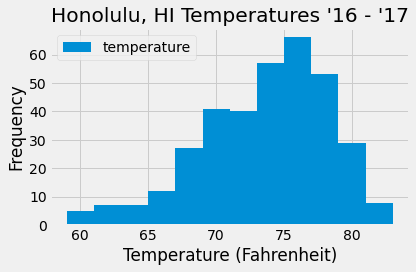

In [109]:
#plot histogram
fig, ax = plt.subplots()
yearly_temps_df.plot.hist(bins = 12, ax = ax)

#set labels
ax.set_xlabel('Temperature (Fahrenheit)')
ax.set_ylabel('Frequency')
ax.set_title("Honolulu, Hawaii Temperatures '16 - '17")

#plot
plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

In [89]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [90]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
trip_temps = calc_temps('2017-01-04', '2017-01-18')

print(f"Lowest Temperature: {trip_temps[0][0]} Fahrenheit")
print(f"Average Temperature: {round(trip_temps[0][1], 2)} Fahrenheit")
print(f"Highest Temperature: {trip_temps[0][2]} Fahrenheit")

Lowest Temperature: 60.0 Fahrenheit
Average Temperature: 69.26 Fahrenheit
Highest Temperature: 81.0 Fahrenheit


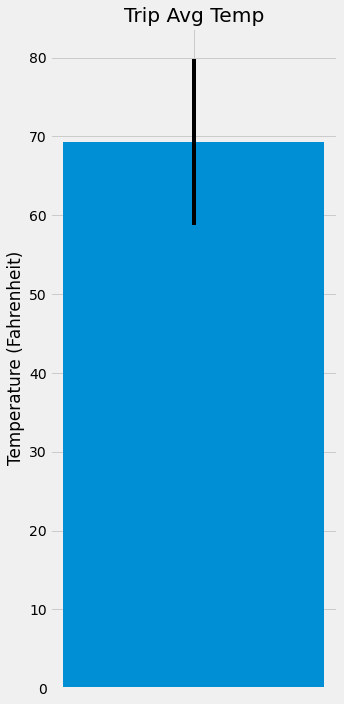

In [92]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
# plot the temperatures as a bar chart, where the average temp is the height and the peak to peak is the error
#bar (tmax - tmin)
pk_to_pk = trip_temps[0][2] - trip_temps[0][0]
avg_temp = trip_temps[0][1]

#plot figure
fig, ax = plt.subplots(figsize = (5, 10))

ax.bar(1, avg_temp, yerr = pk_to_pk/2, width = 0.4)

#set labels
ax.set_xticks([1])
ax.set_xticklabels([""])
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Temperature (Fahrenheit)')


#show figure
plt.tight_layout()
plt.show()


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [93]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

#get average rainfall for each weather station for the last year
yearly_rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude,
                               Station.elevation, func.avg(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= datetime.date(2016, 8, 23)).group_by(Station.station).\
    order_by(func.avg(Measurement.prcp).desc()).all()

#load into a dataframe
yearly_rainfall_df = pd.DataFrame(yearly_rainfall, columns = ['Station', 'Name', 'Latitude', 'Longitude', 
                                                              'Elevation', 'Avg. Precipitation (in.)'])

yearly_rainfall_df

,Station,Name,Latitude,Longitude,Elevation,Avg. Precipitation (in.)
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.450640
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.198949
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.141429
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.125434
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.121051
5,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.076500
6,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.044819


In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [95]:
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [96]:
trip_dates = ["01-04", "01-05", "01-06", "01-07", "01-08", "01-09", "01-10", "01-11", "01-12", "01-13", "01-14",
             "01-15", "01-16", "01-17", "01-18"]

In [97]:
daily_norms = []

for trip_date in trip_dates:
    day = {}
    day['Date'] = f"2019-{trip_date}"
    daily_norm = daily_normals(trip_date)
    day['Min'] = daily_norm[0][0]
    day['Avg'] = daily_norm[0][1]
    day['Max'] = daily_norm[0][2]
    daily_norms.append(day)
    
daily_norms

[{'Date': '2019-01-04', 'Min': 58.0, 'Avg': 70.0, 'Max': 76.0},
 {'Date': '2019-01-05', 'Min': 56.0, 'Avg': 67.96428571428571, 'Max': 76.0},
 {'Date': '2019-01-06', 'Min': 61.0, 'Avg': 68.96491228070175, 'Max': 76.0},
 {'Date': '2019-01-07', 'Min': 57.0, 'Avg': 68.54385964912281, 'Max': 76.0},
 {'Date': '2019-01-08', 'Min': 57.0, 'Avg': 67.16071428571429, 'Max': 75.0},
 {'Date': '2019-01-09', 'Min': 58.0, 'Avg': 67.9298245614035, 'Max': 78.0},
 {'Date': '2019-01-10', 'Min': 62.0, 'Avg': 69.74137931034483, 'Max': 77.0},
 {'Date': '2019-01-11', 'Min': 57.0, 'Avg': 67.3103448275862, 'Max': 78.0},
 {'Date': '2019-01-12', 'Min': 57.0, 'Avg': 67.4074074074074, 'Max': 81.0},
 {'Date': '2019-01-13', 'Min': 57.0, 'Avg': 67.25454545454545, 'Max': 77.0},
 {'Date': '2019-01-14', 'Min': 58.0, 'Avg': 69.52631578947368, 'Max': 77.0},
 {'Date': '2019-01-15', 'Min': 56.0, 'Avg': 69.31372549019608, 'Max': 78.0},
 {'Date': '2019-01-16', 'Min': 54.0, 'Avg': 68.62962962962963, 'Max': 80.0},
 {'Date': '2019

In [ ]:
#load into a data frame
daily_norms_df = pd.DataFrame(daily_norms)

#set index
daily_norms_df.set_index('Date', inplace = True)

#display
daily_norms_df

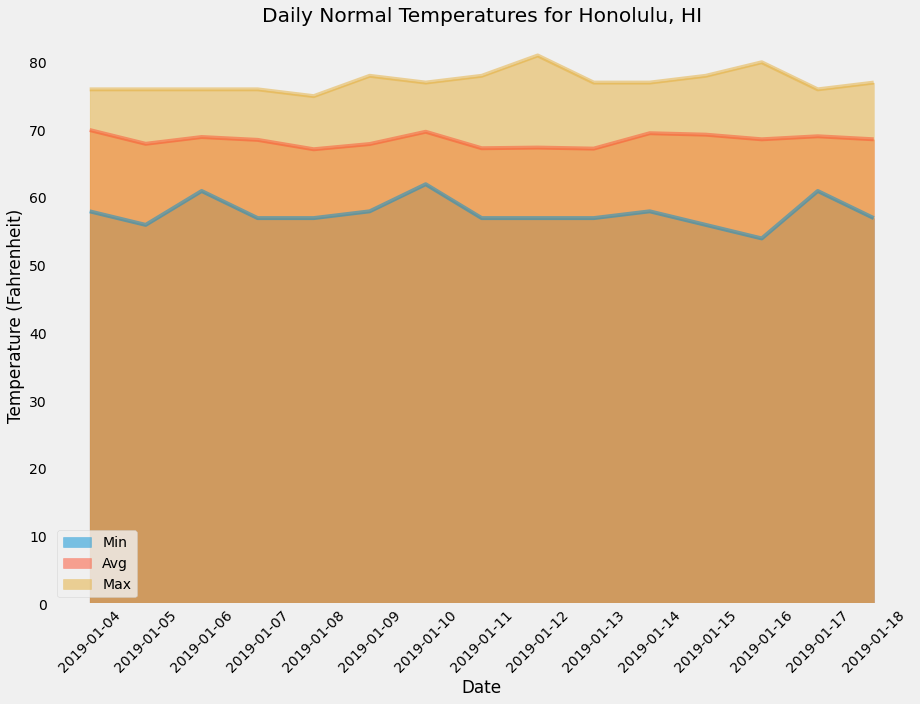

In [101]:
#plot
fig, ax = plt.subplots(figsize = (13, 10))
daily_norms_df.plot.area(ax = ax, stacked = False)

#set labels
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (Fahrenheit)')
ax.set_title('Daily Normal Temperatures for Honolulu, Hawaii')

#set ticks
dates = [f"2019-{trip_date}" for trip_date in trip_dates]
ax.set_xticks(np.arange(len(dates)))
ax.set_xticklabels(dates, rotation = 45)


#show
plt.grid()
plt.tight_layout()
plt.show()